In [1]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os

In [2]:
image_path_1 = "/kaggle/input/wec-underwater/Train/Raw/105_img_.png"
image_path_2 = "/kaggle/input/wec-underwater/Train/Raw/100_img_.png"
img1 = Image.open(image_path_1)
img2 = Image.open(image_path_2)

# Get the shape of the image
width1, height1 = img1.size
width2, height2 = img2.size

print(f"Image 1 shape : {height1} x {width1}")
print(f"Image 2 shape : {height2} x {width2}")

Image 1 shape (width x height): 485 x 366
Image 2 shape (width x height): 800 x 450


Since the shapes of the images are different, and also since the shapes are preserved, I decided to resize the images to 224*224

In [3]:
class UnderwaterImageDataset(Dataset):
    def __init__(self, raw_dir, ref_dir, transforms=None):
        self.raw_dir = raw_dir
        self.ref_dir = ref_dir
        self.transforms = transforms
        self.image_files = [f for f in os.listdir(raw_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        raw_img = Image.open(os.path.join(self.raw_dir, img_name))
        ref_img = Image.open(os.path.join(self.ref_dir, img_name))

        raw_img = self.transforms(raw_img)
        ref_img = self.transforms(ref_img)

        return raw_img, ref_img
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = UnderwaterImageDataset(
    raw_dir='/kaggle/input/wec-underwater/Train/Raw',
    ref_dir='/kaggle/input/wec-underwater/Train/Reference',
    transforms=transform
)

test_dataset = UnderwaterImageDataset(
    raw_dir='/kaggle/input/wec-underwater/Test/Raw',
    ref_dir='/kaggle/input/wec-underwater/Test/Reference',
    transforms=transform
)

In [4]:
import torch.nn as nn
import torch


class VariationalAutoEncoder(nn.Module):
    def __init__(self, features_d):
        super(VariationalAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(

            self._enc_block(
                in_channels=3,
                out_channels=features_d,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            self._enc_block(
                in_channels=features_d,
                out_channels=features_d * 2,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            self._enc_block(
                in_channels=features_d * 2,
                out_channels=features_d * 4,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
        )

        self.conv_mu = nn.Sequential(
            nn.Conv2d(
                features_d * 4, features_d * 4, kernel_size=3, stride=1, padding=1
            ),
            nn.BatchNorm2d(features_d * 4),
            nn.ReLU(),
            nn.Conv2d(
                features_d * 4, features_d * 4, kernel_size=3, stride=1, padding=1
            ),  
        )

        self.conv_logvar = nn.Sequential(
            nn.Conv2d(
                features_d * 4, features_d * 4, kernel_size=3, stride=1, padding=1
            ),
            nn.BatchNorm2d(features_d * 4),
            nn.ReLU(),
            nn.Conv2d(
                features_d * 4, features_d * 4, kernel_size=3, stride=1, padding=1
            ),  
        )

        self.decoder = nn.Sequential(
            self._dec_block(
                in_channels=features_d * 4,
                out_channels=features_d * 2,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            self._dec_block(
                in_channels=features_d * 2,
                out_channels=features_d,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.ConvTranspose2d(
                features_d,
                3,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(3),
            nn.Sigmoid(),
        )

    def _enc_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def _dec_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, imgs):
        x = self.encoder(imgs)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_imgs = self.decoder(z)
        return reconstructed_imgs


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def get_model(features):
    model = VariationalAutoEncoder(features)

    return model


def get_essentials(model, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.0, 0.9))

    criterion = nn.MSELoss()

    return criterion, optimizer

In [5]:
features = 8
lr = 0.001
epoches = 50
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
AutoEncoder = get_model(features)
criterion, optmizer = get_essentials(AutoEncoder, lr)
initialize_weights(AutoEncoder)

In [ ]:
for epoch in range(epoches):
    train_losses = []
    train_l = 0
    AutoEncoder.train()

    # Training loop progress
    for noisy, clean in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epoches} - Training"):
        encoding = AutoEncoder(noisy)

        # Loss
        loss = criterion(encoding, clean)
        train_losses.append(loss.item() * noisy.shape[0])
        train_l += noisy.shape[0]

        # Zero the gradients, perform a backward pass, and update the weights
        optmizer.zero_grad()
        loss.backward()
        optmizer.step()

    print(
        f"Epoch [{epoch+1}/{epoches}] Train Loss: {sum(train_losses)/train_l}"
    )


In [14]:
def save_checkpoint(AutoEncoder, optimizer, epoch, loss, filename="checkpoint_100.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': AutoEncoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch+1}")

In [11]:
def load_checkpoint(AutoEncoder, optimizer, filename="checkpoint.pth"):
    checkpoint = torch.load(filename)
    AutoEncoder.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Loaded checkpoint from epoch {start_epoch+1}")
    return start_epoch

In [12]:
start_epoch = load_checkpoint(AutoEncoder, optmizer) 

for epoch in range(start_epoch + 1, start_epoch+epoches+1):
    train_losses = []
    train_l = 0
    AutoEncoder.train()

    for noisy, clean in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epoches+start_epoch+1} - Training"):
        encoding = AutoEncoder(noisy)
        loss = criterion(encoding, clean)
        train_losses.append(loss.item() * noisy.shape[0])
        train_l += noisy.shape[0]

        optmizer.zero_grad()
        loss.backward()
        optmizer.step()
        
    print(
        f"Epoch [{epoch+1}/{epoches+start_epoch+1}] Train Loss: {sum(train_losses)/train_l}"
        )


/tmp/ipykernel_185/2564274966.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Loaded checkpoint from epoch 50


Epoch 51/100 - Training: 100%|██████████| 22/22 [00:51<00:00,  2.33s/it]


Epoch [51/100] Train Loss: 0.016917471098048347


Epoch 52/100 - Training: 100%|██████████| 22/22 [00:49<00:00,  2.27s/it]


Epoch [52/100] Train Loss: 0.017154064210397856


Epoch 53/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [53/100] Train Loss: 0.016869766126785958


Epoch 54/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.29s/it]


Epoch [54/100] Train Loss: 0.01709612540900707


Epoch 55/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.29s/it]


Epoch [55/100] Train Loss: 0.01671581991016865


Epoch 56/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.29s/it]


Epoch [56/100] Train Loss: 0.01684387916965144


Epoch 57/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.30s/it]


Epoch [57/100] Train Loss: 0.016977098866232804


Epoch 58/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [58/100] Train Loss: 0.016832336357661657


Epoch 59/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [59/100] Train Loss: 0.016503986966397082


Epoch 60/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [60/100] Train Loss: 0.016557278601186616


Epoch 61/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [61/100] Train Loss: 0.016510104936148438


Epoch 62/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.29s/it]


Epoch [62/100] Train Loss: 0.01658318483403751


Epoch 63/100 - Training: 100%|██████████| 22/22 [00:49<00:00,  2.26s/it]


Epoch [63/100] Train Loss: 0.01632966000054564


Epoch 64/100 - Training: 100%|██████████| 22/22 [00:49<00:00,  2.27s/it]


Epoch [64/100] Train Loss: 0.0165139931759664


Epoch 65/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.30s/it]


Epoch [65/100] Train Loss: 0.016470385598284856


Epoch 66/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [66/100] Train Loss: 0.01637013666331768


Epoch 67/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.27s/it]


Epoch [67/100] Train Loss: 0.01639859428363187


Epoch 68/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.27s/it]


Epoch [68/100] Train Loss: 0.01641120738216809


Epoch 69/100 - Training: 100%|██████████| 22/22 [00:49<00:00,  2.25s/it]


Epoch [69/100] Train Loss: 0.016458875824298176


Epoch 70/100 - Training: 100%|██████████| 22/22 [00:49<00:00,  2.27s/it]


Epoch [70/100] Train Loss: 0.016166576029998915


Epoch 71/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [71/100] Train Loss: 0.01628326754484858


Epoch 72/100 - Training: 100%|██████████| 22/22 [00:49<00:00,  2.26s/it]


Epoch [72/100] Train Loss: 0.01628870468054499


Epoch 73/100 - Training: 100%|██████████| 22/22 [00:49<00:00,  2.26s/it]


Epoch [73/100] Train Loss: 0.016033607753259797


Epoch 74/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.27s/it]


Epoch [74/100] Train Loss: 0.016108314810054643


Epoch 75/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [75/100] Train Loss: 0.016259053626230785


Epoch 76/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [76/100] Train Loss: 0.01607230803796223


Epoch 77/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.29s/it]


Epoch [77/100] Train Loss: 0.01596918771309512


Epoch 78/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.29s/it]


Epoch [78/100] Train Loss: 0.01592140427657536


Epoch 79/100 - Training: 100%|██████████| 22/22 [00:49<00:00,  2.26s/it]


Epoch [79/100] Train Loss: 0.015816353346620286


Epoch 80/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.30s/it]


Epoch [80/100] Train Loss: 0.016022898757031986


Epoch 81/100 - Training: 100%|██████████| 22/22 [00:49<00:00,  2.26s/it]


Epoch [81/100] Train Loss: 0.015884192309209278


Epoch 82/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.31s/it]


Epoch [82/100] Train Loss: 0.016001592480710574


Epoch 83/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [83/100] Train Loss: 0.01592048691851752


Epoch 84/100 - Training: 100%|██████████| 22/22 [00:49<00:00,  2.27s/it]


Epoch [84/100] Train Loss: 0.01598105502980096


Epoch 85/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [85/100] Train Loss: 0.016005156561732292


Epoch 86/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [86/100] Train Loss: 0.01583529212645122


Epoch 87/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.30s/it]


Epoch [87/100] Train Loss: 0.01599784688225814


Epoch 88/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.29s/it]


Epoch [88/100] Train Loss: 0.015945622394127505


Epoch 89/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.30s/it]


Epoch [89/100] Train Loss: 0.015717313545090813


Epoch 90/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.31s/it]


Epoch [90/100] Train Loss: 0.015944092752678055


Epoch 91/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [91/100] Train Loss: 0.01607976423310382


Epoch 92/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.31s/it]


Epoch [92/100] Train Loss: 0.01583727819578988


Epoch 93/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [93/100] Train Loss: 0.015697028817875044


Epoch 94/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.30s/it]


Epoch [94/100] Train Loss: 0.015795153150601045


Epoch 95/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.28s/it]


Epoch [95/100] Train Loss: 0.015774857295410973


Epoch 96/100 - Training: 100%|██████████| 22/22 [00:51<00:00,  2.32s/it]


Epoch [96/100] Train Loss: 0.015732743670897824


Epoch 97/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.30s/it]


Epoch [97/100] Train Loss: 0.015654905544860022


Epoch 98/100 - Training: 100%|██████████| 22/22 [00:49<00:00,  2.27s/it]


Epoch [98/100] Train Loss: 0.015659318385379654


Epoch 99/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.31s/it]


Epoch [99/100] Train Loss: 0.01574818754834788


Epoch 100/100 - Training: 100%|██████████| 22/22 [00:50<00:00,  2.27s/it]

Epoch [100/100] Train Loss: 0.01564406227852617


In [15]:
save_checkpoint(AutoEncoder, optmizer, epoch, loss)

Checkpoint saved at epoch 100


In [18]:
torch.save(AutoEncoder.state_dict(), "vae_underwater_100_epochs.pth")


In [16]:
def transform_to_224(image_path):
    resize_transform_224 = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor()   
    ])
    
    image = Image.open(image_path)
    resized_image_224 = resize_transform_224(image)
    enhanced_img = transforms.ToPILImage()(resized_image_224)

    plt.imshow(enhanced_img)
    plt.axis('off') 
    plt.show() 
    return resized_image_256

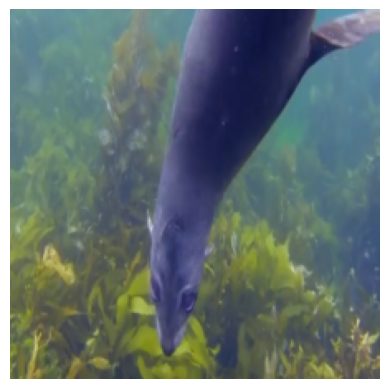

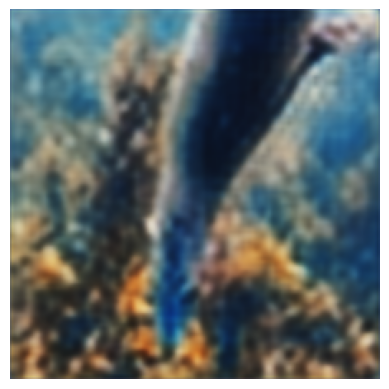

In [17]:
raw_img = transform_to_256("/kaggle/input/wec-underwater/Test/Raw/10909.png")

raw_img = raw_img.unsqueeze(0)

AutoEncoder.eval()

with torch.no_grad():

    enhanced_img = AutoEncoder(raw_img) 
    enhanced_img = enhanced_img.squeeze(0)
    enhanced_img = transforms.ToPILImage()(enhanced_img)

    plt.imshow(enhanced_img)
    plt.axis('off')  
    plt.show() 